In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2024/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2024


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter

pd.set_option('display.max_columns', 500)

import dateutil
from math import radians
from IPython.display import Video

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# tracking = pd.read_csv("./clean_tracking.csv")
# tracking = spark.read.option("header",'True').parquet("./clean_tracking.parquet")
tackle = pd.read_csv('./nfl-big-data-bowl-2024/tackles.csv')
games = pd.read_csv('./nfl-big-data-bowl-2024/games.csv')
plays = pd.read_csv('./nfl-big-data-bowl-2024/plays.csv')

In [ ]:
tackle.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [ ]:
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,passLength,penaltyYards,prePenaltyPlayResult,playResult,playNullifiedByPenalty,absoluteYardlineNumber,offenseFormation,defendersInTheBox,passProbability,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,ATL,41,7:52,21,7,C,6.0,NaN,9,9,N,69,SHOTGUN,7.0,0.747284,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,PIT,34,7:38,14,20,NaN,NaN,NaN,3,3,N,76,SHOTGUN,7.0,0.416454,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,LV,30,8:57,10,3,C,11.0,NaN,15,15,N,40,I_FORM,6.0,0.267933,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,DEN,37,13:12,19,16,NaN,NaN,NaN,7,7,N,47,SINGLEBACK,6.0,0.592704,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,TEN,35,8:33,7,7,NaN,NaN,NaN,3,3,N,75,I_FORM,7.0,0.470508,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


# Yds/Play Tackles vs Mistackles

On plays where a tackle attempt is made, I hypothesize that those plays without a mistackle will have a lower yds/play than those plays with a mistackle.

In [ ]:
tackle_attempt = tackle.groupby(by=['gameId',	'playId']).sum().reset_index()
# tackle_attempt[(tackle_attempt['tackle']>=1) | (tackle_attempt['assist']>=1) | (tackle_attempt['forcedFumble']>=1) | (tackle_attempt['pff_missedTackle']>=1)]
tackle_attempt['mistackle'] = np.where((tackle_attempt['pff_missedTackle']>=1),1,0)
tackle_attempt = tackle_attempt[['gameId',	'playId', 'mistackle']]
tackle_attempt.head()

,gameId,playId,mistackle
0,2022090800,56,0
1,2022090800,80,0
2,2022090800,101,0
3,2022090800,122,0
4,2022090800,146,0


In [ ]:
plays_no_penalty = plays[plays['playNullifiedByPenalty']=='N']

In [ ]:
mistackle_result = plays_no_penalty[['gameId',	'playId', 'playResult']].merge(tackle_attempt, on=['gameId',	'playId'], how='left')
mistackle_result.head()

,gameId,playId,playResult,mistackle
0,2022100908,3537,9,0.0
1,2022091103,3126,3,1.0
2,2022091111,1148,15,0.0
3,2022100212,2007,7,1.0
4,2022091900,1372,3,1.0


In [ ]:
avg_result = mistackle_result[['playResult']]
print(avg_result.mean())
avg_mistackle_result = mistackle_result[mistackle_result['mistackle']==1][['playResult']]
print(avg_mistackle_result.mean())
avg_tackle_result = mistackle_result[mistackle_result['mistackle']==0][['playResult']]
print(avg_tackle_result.mean())

playResult    7.5933
dtype: float64
playResult    10.945087
dtype: float64
playResult    6.784518
dtype: float64


In [ ]:
from scipy import stats

t_value, p_value = stats.ttest_ind(avg_tackle_result,
                                   avg_mistackle_result)

print(t_value)
print(p_value)

[-18.8098805]
[8.75496308e-78]


Great! The data gives evidence that when a play has a mistackle, then then yds/play is greater than when there isn't a mistackle. This is also a statistically significant difference between regular play and mistackles. We reject the null hpothesis and accept the alternative that there is a difference b/w average play and plays with mistackles at the 95% confidence level.

In [ ]:
mistackle_result.head()

,gameId,playId,playResult,mistackle
0,2022100908,3537,9,0.0
1,2022091103,3126,3,1.0
2,2022091111,1148,15,0.0
3,2022100212,2007,7,1.0
4,2022091900,1372,3,1.0


In [ ]:
mistackle_result[mistackle_result['playResult']<-30]

,gameId,playId,playResult,mistackle
747,2022100212,1461,-59,0.0
1568,2022092500,586,-45,0.0
1755,2022110600,2183,-39,0.0
11540,2022091811,4519,-61,1.0


In [ ]:
pd.set_option('display.max_colwidth', None)

plays[(plays['gameId']==2022092500) & (plays['playId']==586)]['playDescription']

1623    (5:44) A.Kamara right tackle to NO 43 for -2 yards (F.Luvu). FUMBLES (F.Luvu), touched at NO 42, RECOVERED by CAR-M.Haynes at NO 44. M.Haynes for 44 yards, TOUCHDOWN. Penalty on NO-N.Vannett, Offensive Holding, declined.
Name: playDescription, dtype: object

In [ ]:
plays_no_to = plays[(~plays["playDescription"].str.contains('FUMBLE')) & (~plays["playDescription"].str.contains('INTERCEPT'))]
plays_no_to_no_penalty = plays_no_to[plays_no_to['playNullifiedByPenalty']=='N']
mistackle_no_to_result = plays_no_to_no_penalty[['gameId',	'playId', 'playResult']].merge(tackle_attempt, on=['gameId',	'playId'], how='left')
t_value, p_value = stats.ttest_ind(mistackle_no_to_result[mistackle_no_to_result['mistackle']==0][['playResult']],
                                   mistackle_no_to_result[mistackle_no_to_result['mistackle']==1][['playResult']])

print(t_value)
print(p_value)

[-19.19607146]
[7.13863324e-81]


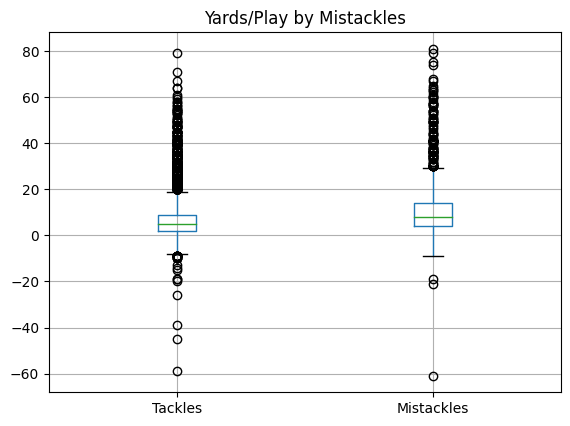

In [ ]:
# data = [[avg_result],[avg_mistackle_result]]
# data
mistackle_result.boxplot(column = 'playResult',by='mistackle')
plt.title( 'Yards/Play by Mistackles' )
plt.suptitle('')
plt.xlabel('')
plt.xticks([1,2], ['Tackles', 'Mistackles'])
plt.savefig('./mistackles_avg_result.png')

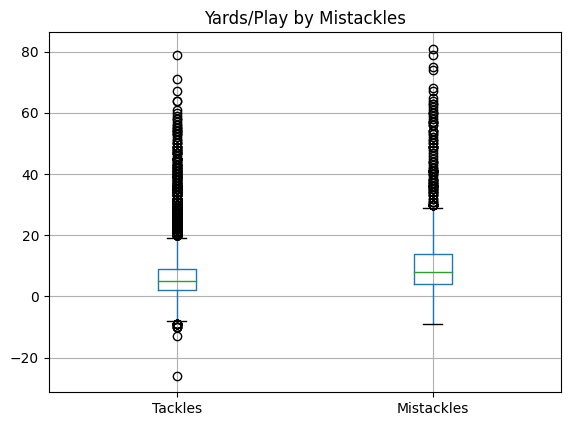

In [ ]:
# data = [[avg_result],[avg_mistackle_result]]
# data
mistackle_no_to_result.boxplot(column = 'playResult',by='mistackle')
plt.title( 'Yards/Play by Mistackles' )
plt.suptitle('')
plt.xlabel('')
plt.xticks([1,2], ['Tackles', 'Mistackles'])
plt.savefig('./mistackles_avg_result.png')